In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install vecstack


Mounted at /content/drive
  Preparing metadata (setup.py) ... done
  Created wheel for vecstack: filename=vecstack-0.4.0-py3-none-any.whl size=19861 sha256=76a31f2fe9db2e60ba6125f7cce4df57c5718f433a3e572d22854cd5d5b62543
  Stored in directory: /root/.cache/pip/wheels/b8/d8/51/3cf39adf22c522b0a91dc2208db4e9de4d2d9d171683596220
Successfully built vecstack


In [41]:
from vecstack import stacking
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

In [3]:
#Read training data file

trainfile = '/content/drive/MyDrive/Colab Notebooks/Cell Phone Churn-TRAIN.csv'
trainData = pd.read_csv(trainfile)

#Read test data file
testfile = '/content/drive/MyDrive/Colab Notebooks/Cell Phone Churn-TEST.csv'
testData = pd.read_csv(testfile)

In [4]:
print(trainData.shape)
print(testData.shape)

(1695, 24)
(375, 24)


In [5]:
trainData.head()


,MOUMO,MOUPMO,MOU3MO,MOUCH1M,MOUCH3M,CUM3MCH,CUSTMOS,LONGD,CALLW,LINES,...,INCOME,SPORTS,NATURE,ARTS,HRS_TV,TRAVEL,EDUC,TOTMOU,TOTCHNG,TARGET
0,105,15,99,90,-84,6,11,0,0,2,...,51000,B,1,N,10,None,Bachelors,219,6,0
1,999,1200,1145,-201,55,-146,3,1,1,2,...,80000,A,0,N,40,Domestic,Masters,3344,-146,1
2,5,2,1,3,1,4,23,0,0,1,...,80000,C,0,Y,50,International,HighSchool,8,4,1
3,600,456,398,144,58,202,13,0,1,1,...,88000,A,1,N,0,International,Masters,1454,202,1
4,2,0,0,0,0,0,1,0,0,1,...,29000,B,0,N,75,Domestic,HighSchool,0,0,0


In [6]:
testData.head()

,MOUMO,MOUPMO,MOU3MO,MOUCH1M,MOUCH3M,CUM3MCH,CUSTMOS,LONGD,CALLW,LINES,...,INCOME,SPORTS,NATURE,ARTS,HRS_TV,TRAVEL,EDUC,TOTMOU,TOTCHNG,TARGET
0,344,232,455,112,-223,-111,11,1,1,2,...,75000,B,1,Y,25,InterGalactic,GED,1031,-111,0
1,555,444,678,111,-234,-123,27,1,1,2,...,134000,na,1,Y,5,Domestic,PhD,1677,-123,0
2,2,0,4,1,-3,-2,4,0,0,1,...,53000,na,1,Y,125,None,Bachelors,6,-2,0
3,5678,3457,2156,2221,1301,3522,14,1,1,1,...,33000,A,1,Y,25,Domestic,Masters,11291,3522,0
4,333,122,144,211,-22,189,9,0,1,1,...,44000,F,1,N,35,International,Masters,599,189,1


In [8]:
Ytrain = trainData['TARGET']
Ytest = testData['TARGET']
combinedData = pd.concat([trainData,testData], keys=[0,1])
combinedData.drop(['TARGET'], axis=1, inplace=True)
combinedData.shape

(2070, 23)

In [9]:
missing_values = combinedData.isnull().sum()
missing_values[missing_values > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [10]:
combinedData.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2070 entries, (0, 0) to (1, 374)
Data columns (total 23 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MOUMO    2070 non-null   int64 
 1   MOUPMO   2070 non-null   int64 
 2   MOU3MO   2070 non-null   int64 
 3   MOUCH1M  2070 non-null   int64 
 4   MOUCH3M  2070 non-null   int64 
 5   CUM3MCH  2070 non-null   int64 
 6   CUSTMOS  2070 non-null   int64 
 7   LONGD    2070 non-null   int64 
 8   CALLW    2070 non-null   int64 
 9   LINES    2070 non-null   int64 
 10  VOICEM   2070 non-null   int64 
 11  CELL     2070 non-null   int64 
 12  CONVB    2070 non-null   object
 13  SEX      2070 non-null   object
 14  INCOME   2070 non-null   int64 
 15  SPORTS   2070 non-null   object
 16  NATURE   2070 non-null   int64 
 17  ARTS     2070 non-null   object
 18  HRS_TV   2070 non-null   int64 
 19  TRAVEL   2070 non-null   object
 20  EDUC     2070 non-null   object
 21  TOTMOU   2070 non-null   int

In [12]:
categorical_columns = combinedData.select_dtypes(include=['object']).columns
TrainCols = list(categorical_columns.values)
print(TrainCols)

['CONVB', 'SEX', 'SPORTS', 'ARTS', 'TRAVEL', 'EDUC']


In [13]:
combinedData = pd.get_dummies(combinedData,columns=TrainCols)
combinedData.shape

(2070, 40)

In [15]:
Xtrain = combinedData.xs(0)
Xtest = combinedData.xs(1)
print(Xtrain.shape)
print(Xtest.shape)

(1695, 40)
(375, 40)


In [18]:
print(Ytrain.value_counts())
print(Ytest.value_counts())

0    1052
1     643
Name: TARGET, dtype: int64
0    235
1    140
Name: TARGET, dtype: int64


In [31]:
dt = DecisionTreeClassifier()
dt.fit(Xtrain, Ytrain)
dt_pred = dt.predict(Xtest)
#Model Accuracy
print("Accuracy:", accuracy_score(Ytest, dt_pred))
print("Precision:", precision_score(Ytest, dt_pred))
print("Recall:", recall_score(Ytest, dt_pred))
print("F1 Score:", f1_score(Ytest, dt_pred))
print("ROC-AUC Score:", roc_auc_score(Ytest, dt_pred))
print("Confusion Matrix:\n", confusion_matrix(Ytest, dt_pred))

Accuracy: 0.9946666666666667
Precision: 1.0
Recall: 0.9857142857142858
F1 Score: 0.9928057553956835
ROC-AUC Score: 0.9928571428571429
Confusion Matrix:
 [[235   0]
 [  2 138]]


In [20]:
svc = LinearSVC()
svc.fit(Xtrain, Ytrain)
svc_pred = svc.predict(Xtest)

# Model Accuracy
print("Accuracy:", accuracy_score(Ytest, svc_pred))
print("Precision:", precision_score(Ytest, svc_pred))
print("Recall:", recall_score(Ytest, svc_pred))
print("F1 Score:", f1_score(Ytest, svc_pred))
print("ROC-AUC Score:", roc_auc_score(Ytest, svc_pred))
print("Confusion Matrix:\n", confusion_matrix(Ytest, svc_pred))

Accuracy: 0.5653333333333334
Precision: 0.46204620462046203
Recall: 1.0
F1 Score: 0.6320541760722347
ROC-AUC Score: 0.6531914893617021
Confusion Matrix:
 [[ 72 163]
 [  0 140]]


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [24]:
knn = KNeighborsClassifier(n_jobs = -1)
knn.fit(Xtrain, Ytrain)
knn_pred = knn.predict(Xtest)
#Model Accuracy
print("Accuracy:", accuracy_score(Ytest, knn_pred))
print("Precision:", precision_score(Ytest, knn_pred))
print("Recall:", recall_score(Ytest, knn_pred))
print("F1 Score:", f1_score(Ytest, knn_pred))
print("ROC-AUC Score:", roc_auc_score(Ytest, knn_pred))
print("Confusion Matrix:\n", confusion_matrix(Ytest, knn_pred))

Accuracy: 0.9946666666666667
Precision: 1.0
Recall: 0.9857142857142858
F1 Score: 0.9928057553956835
ROC-AUC Score: 0.9928571428571429
Confusion Matrix:
 [[235   0]
 [  2 138]]


In [21]:
mlp = MLPClassifier()

# Fit the model on the training data
mlp.fit(Xtrain, Ytrain)

# Predict on the test data
mlp_pred = mlp.predict(Xtest)

# Model Accuracy
print("Accuracy:", accuracy_score(Ytest, mlp_pred))
print("Precision:", precision_score(Ytest, mlp_pred))
print("Recall:", recall_score(Ytest, mlp_pred))
print("F1 Score:", f1_score(Ytest, mlp_pred))
print("ROC-AUC Score:", roc_auc_score(Ytest, mlp_pred))
print("Confusion Matrix:\n", confusion_matrix(Ytest, mlp_pred))

Accuracy: 0.7493333333333333
Precision: 0.8194444444444444
Recall: 0.42142857142857143
F1 Score: 0.5566037735849056
ROC-AUC Score: 0.6830547112462007
Confusion Matrix:
 [[222  13]
 [ 81  59]]


In [29]:
parameters={'min_samples_split' : range(10,200,20),
            'max_depth': range(1,30),
            'criterion':['gini','entropy'],
            'max_leaf_nodes' : range(10,30),
            'max_features' : range(20,30)
            }

In [30]:
#Hyperparameter tuning done for decision tree classifier
clf_random = RandomizedSearchCV(dt,parameters,n_iter=100, cv = 5, scoring = "roc_auc", verbose = 2)
clf_random.fit(Xtrain, Ytrain)
random_parm = clf_random.best_params_
best_score = clf_random.best_score_
print(f"Best Parameters: ",random_parm)
print(f"Best Score: ",best_score)
print('\n')


#Using the parameters obtained from HyperParameterTuning in the DecisionTreeClassifier
dt = DecisionTreeClassifier(**random_parm, random_state = 7)
dt.fit(Xtrain, Ytrain)
rs_pred = dt.predict(Xtest)

#Obtain accuracy ,confusion matrix,classification report and AUC values for the result above.
print("Accuracy:", accuracy_score(Ytest, rs_pred))
print("Precision:", precision_score(Ytest, rs_pred))
print("Recall:", recall_score(Ytest, rs_pred))
print("F1 Score:", f1_score(Ytest, rs_pred))
print("ROC-AUC Score:", roc_auc_score(Ytest, rs_pred))
print("Confusion Matrix:\n", confusion_matrix(Ytest, rs_pred))
print('\n')

#get cross-validation report
dt_cv_score = cross_val_score(dt, Xtrain, Ytrain, cv=10, scoring="roc_auc")
print("=== All ROC-AUC Scores ===")
print(dt_cv_score)
print('\n')
print("Mean ROC-AUC Score - Decision Tree: ",dt_cv_score.mean())


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END criterion=entropy, max_depth=20, max_features=26, max_leaf_nodes=27, min_samples_split=30; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=26, max_leaf_nodes=27, min_samples_split=30; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=26, max_leaf_nodes=27, min_samples_split=30; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=26, max_leaf_nodes=27, min_samples_split=30; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=26, max_leaf_nodes=27, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=29, max_leaf_nodes=27, min_samples_split=70; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=29, max_leaf_nodes=27, min_samples_split=70; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=29, max_leaf_nodes=27, min_samples_split=70; total time=   0.

In [37]:
feature_importances = dt.feature_importances_
#print(feature_importances)
feature_names = Xtrain.columns
#print(feature_names)
indices = np.argsort(feature_importances)[::-1]
print("Top 5 feature importances:")
for i in range(5):
    if i < len(feature_names):
        print(f"{feature_names[indices[i]]}: {feature_importances[indices[i]]}")

Top 5 feature importances:
MOUCH3M: 0.5466820117605746
INCOME: 0.21047671337593152
MOUPMO: 0.047675246306600874
CUM3MCH: 0.043098855527626455
MOU3MO: 0.034262718192568604


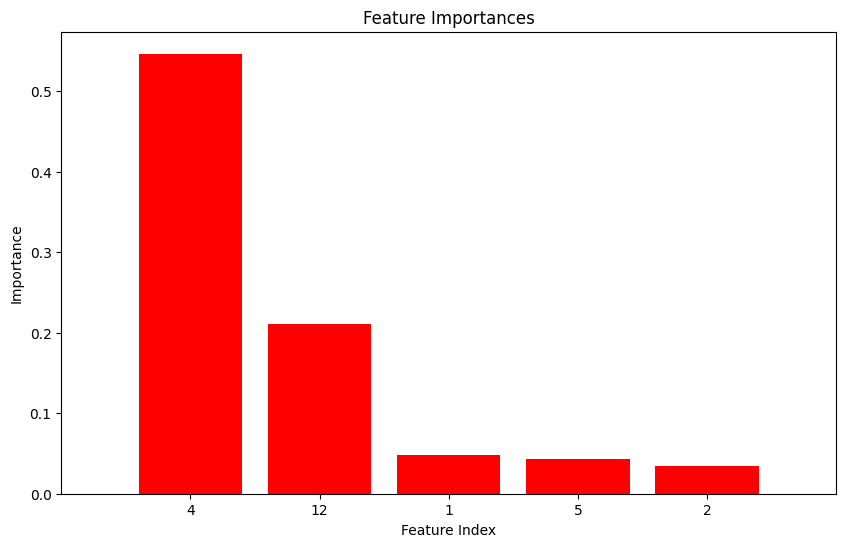

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming dt is your trained DecisionTreeClassifier model from sklearn

# Get feature importances
importances = dt.feature_importances_

# Sort the feature importances in descending order and take the indices of the top 5
indices = np.argsort(importances)[::-1][:5]

# Now plot the top 5 feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(5), importances[indices], color="r", align="center")
plt.xticks(range(5), indices)
plt.xlim([-1, 5])
plt.xlabel('Feature Index')
plt.ylabel('Importance')

# Show the plot
plt.show()


In [52]:
models = [ MLPClassifier(), KNeighborsClassifier(), LinearSVC(), DecisionTreeClassifier() ]

S_Train, S_Test = stacking(models,
                           Xtrain, Ytrain, Xtest,
                           regression=False,

                           mode='oof_pred_bag',

                           needs_proba=False,

                           save_dir=None,

                           metric=roc_auc_score,

                           n_folds=5,

                           stratified=True,

                           shuffle=True,

                           random_state=7,

                           verbose=2)


task:         [classification]
n_classes:    [2]
metric:       [roc_auc_score]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [MLPClassifier]
    fold  0:  [0.63588566]
    fold  1:  [0.49775992]
    fold  2:  [0.62464009]
    fold  3:  [0.62314507]
    fold  4:  [0.72281285]
    ----
    MEAN:     [0.62084872] + [0.07182380]
    FULL:     [0.62033659]

model  1:     [KNeighborsClassifier]
    fold  0:  [0.98744816]
    fold  1:  [0.99135441]
    fold  2:  [0.97973422]
    fold  3:  [0.98510520]
    fold  4:  [0.98986711]
    ----
    MEAN:     [0.98670182] + [0.00408214]
    FULL:     [0.98669349]

model  2:     [LinearSVC]
    fold  0:  [0.53515625]
    fold  1:  [0.55602044]
    fold  2:  [0.51074197]
    fold  3:  [0.56888151]
    fold  4:  [0.53372093]
    ----
    MEAN:     [0.54090422] + [0.02002812]
    FULL:     [0.54077695]

model  3:     [DecisionTreeClassifier]
    fold  0:  [0.98744816]
    fold  1:  [0.99135441]
    fold  2:  [0.97973422]
    fold  3:  [0.9

In [53]:
rf = RandomForestClassifier(random_state = 7, n_jobs = -1)
rf.fit(S_Train, Ytrain)
rf_pred = rf.predict(S_Test)
#Model Accuracy
print("Accuracy:", accuracy_score(Ytest, rf_pred))
print("Precision:", precision_score(Ytest, rf_pred))
print("Recall:", recall_score(Ytest, rf_pred))
print("F1 Score:", f1_score(Ytest, rf_pred))
print("ROC-AUC Score:", roc_auc_score(Ytest, rf_pred))
print("Confusion Matrix:\n", confusion_matrix(Ytest, rf_pred))

Accuracy: 0.9946666666666667
Precision: 1.0
Recall: 0.9857142857142858
F1 Score: 0.9928057553956835
ROC-AUC Score: 0.9928571428571429
Confusion Matrix:
 [[235   0]
 [  2 138]]


In [54]:
models_2 = [LinearSVC(), DecisionTreeClassifier() ]

S_Train1, S_Test1 = stacking(models_2,
                           Xtrain, Ytrain, Xtest,
                           regression=False,

                           mode='oof_pred_bag',

                           needs_proba=False,

                           save_dir=None,

                           metric=roc_auc_score,

                           n_folds=5,

                           stratified=True,

                           shuffle=True,

                           random_state=7,

                           verbose=2)


task:         [classification]
n_classes:    [2]
metric:       [roc_auc_score]
mode:         [oof_pred_bag]
n_models:     [2]

model  0:     [LinearSVC]
    fold  0:  [0.65165877]
    fold  1:  [0.54450533]
    fold  2:  [0.51550388]
    fold  3:  [0.55725360]
    fold  4:  [0.50714286]
    ----
    MEAN:     [0.55521289] + [0.05159100]
    FULL:     [0.55505103]

model  1:     [DecisionTreeClassifier]
    fold  0:  [0.98744816]
    fold  1:  [0.99135441]
    fold  2:  [0.97973422]
    fold  3:  [0.98510520]
    fold  4:  [0.98986711]
    ----
    MEAN:     [0.98670182] + [0.00408214]
    FULL:     [0.98669349]



In [56]:
rf = RandomForestClassifier(random_state = 7)
rf.fit(S_Train1, Ytrain)
rf_pred = rf.predict(S_Test1)
#Model Accuracy
print("Accuracy:", accuracy_score(Ytest, rf_pred))
print("Precision:", precision_score(Ytest, rf_pred))
print("Recall:", recall_score(Ytest, rf_pred))
print("F1 Score:", f1_score(Ytest, rf_pred))
print("ROC-AUC Score:", roc_auc_score(Ytest, rf_pred))
print("Confusion Matrix:\n", confusion_matrix(Ytest, rf_pred))

Accuracy: 0.9946666666666667
Precision: 1.0
Recall: 0.9857142857142858
F1 Score: 0.9928057553956835
ROC-AUC Score: 0.9928571428571429
Confusion Matrix:
 [[235   0]
 [  2 138]]
